# Data Wrangling

In this notebook we are using a public dataset available in kaggle. The data are collected through a survey from Stack Overflow for its users. Here we clean up this dataset. We will check for and handle duplicated rows, missing values, outliers. The rest of data processing that might be useful for the process of exploratory data analysis such as normalisation and data transformation will be done in another notebook.

In [1]:
# Import relevant libraries and load dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("berkayalan/stack-overflow-annual-developer-survey-2024")

# Check the downloaded directory and upload dataset
for root, dirs, files in os.walk(path):
    for file in files:
        if "public.csv" in file:
            df = pd.read_csv(os.path.join(root,file))

df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


In [2]:
print("The shape of the dataset is: ", df.shape)

The shape of the dataset is:  (65437, 114)


We look now at the columns of the dataset and relative data types

In [3]:
for col in df.columns:
    print(f"{'Column:':<10} {col:<30} {'Dtype:':<10} {df[col].dtype}")


Column:    ResponseId                     Dtype:     int64
Column:    MainBranch                     Dtype:     object
Column:    Age                            Dtype:     object
Column:    Employment                     Dtype:     object
Column:    RemoteWork                     Dtype:     object
Column:    Check                          Dtype:     object
Column:    CodingActivities               Dtype:     object
Column:    EdLevel                        Dtype:     object
Column:    LearnCode                      Dtype:     object
Column:    LearnCodeOnline                Dtype:     object
Column:    TechDoc                        Dtype:     object
Column:    YearsCode                      Dtype:     object
Column:    YearsCodePro                   Dtype:     object
Column:    DevType                        Dtype:     object
Column:    OrgSize                        Dtype:     object
Column:    PurchaseInfluence              Dtype:     object
Column:    BuyNewTool                    

For the purposes of our analysis, we are mainly interested mostly in technologies currently used and new trends eemerging.

### Finding duplicates

We first identify how many duplicate rows there are. We use for this purpose the columns with indexes ranging from MainBranch to Country. If these informations are replicated, we can consider that the same individual submitted the survey twice.

In [4]:
subset = list(df.columns[1:20])

duplicated = df[df.duplicated(subset= subset, keep = "first")]
duplicated_num = len(duplicated)
print(f"There are {duplicated_num} duplicated rows")

There are 3033 duplicated rows


We can have a quick look at age ranges and employment type of duplicated rows.

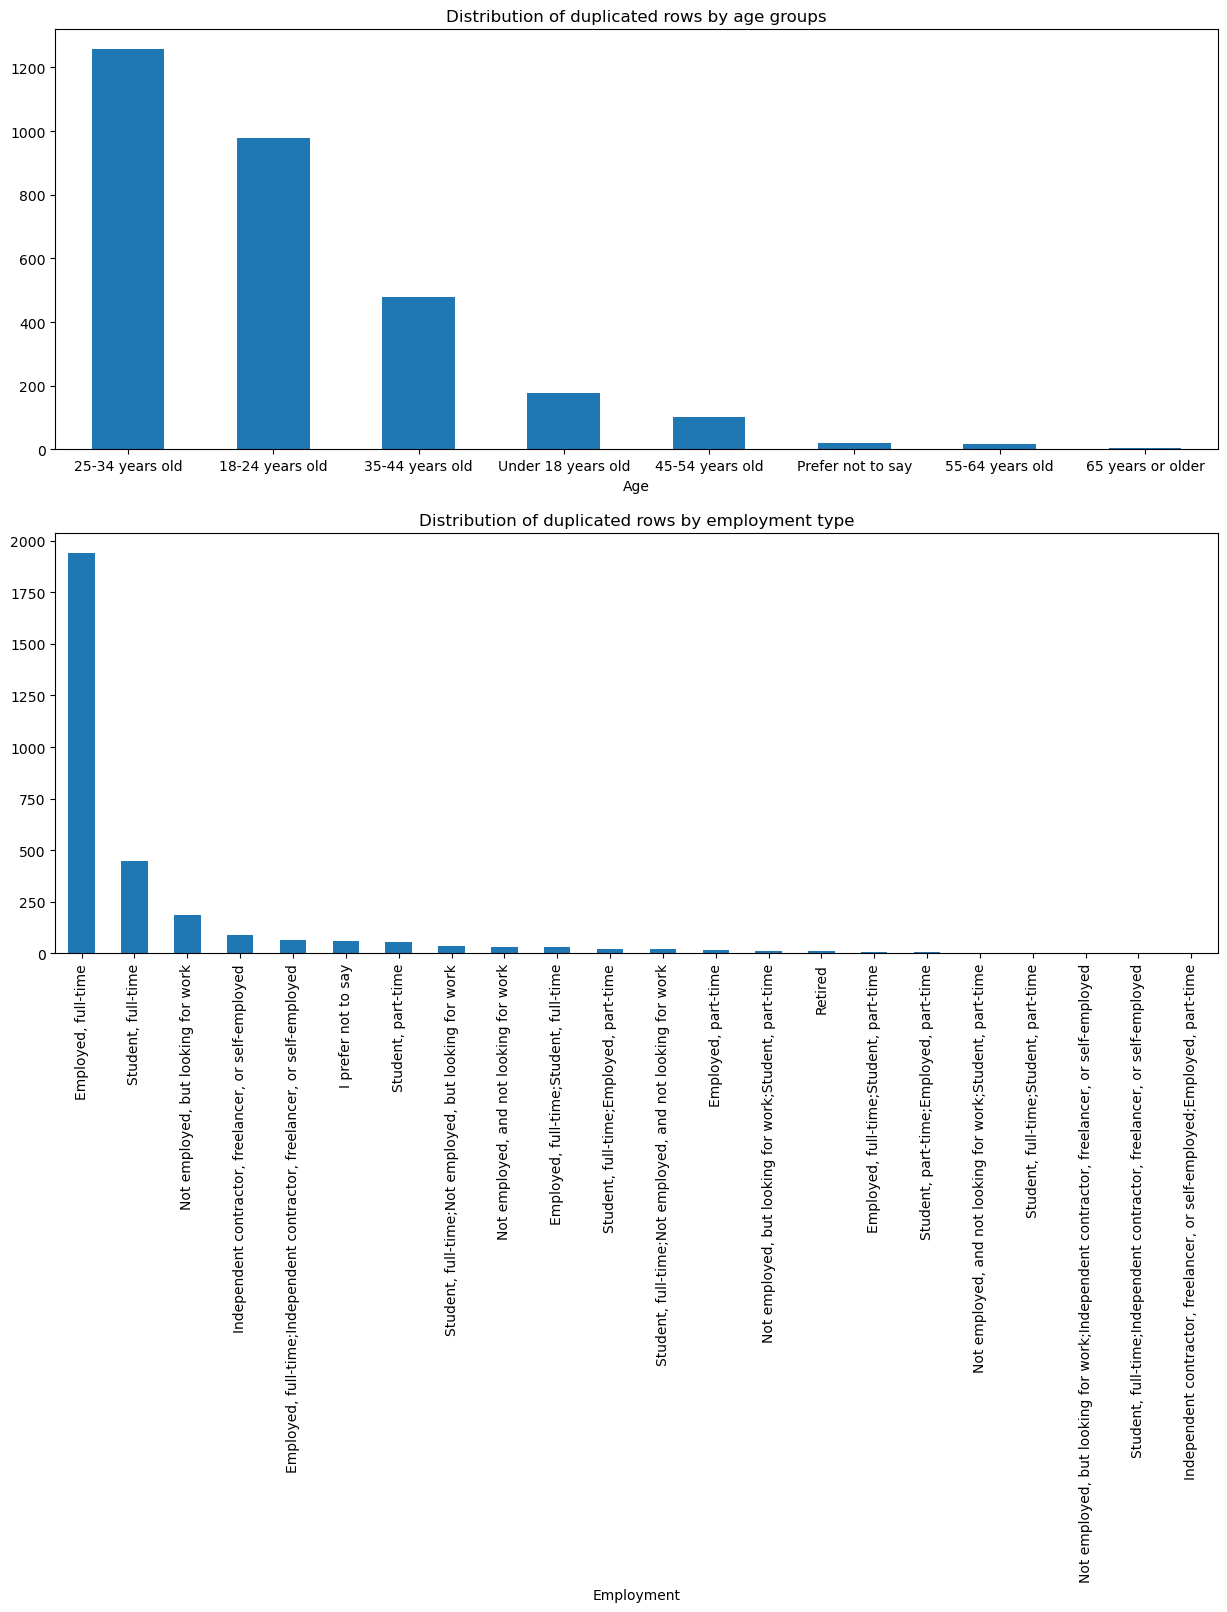

In [5]:
country_count = duplicated["Age"].value_counts()
employment_count = duplicated["Employment"].value_counts()
fig = plt.figure()

ax0 = fig.add_subplot(2, 1,1) # add subplot 1 (1 row, 2 columns, first plot)
country_count.plot(kind = "bar", figsize = (15,14))
plt.title("Distribution of duplicated rows by age groups")
plt.xticks(rotation = 360)
ax1 = fig.add_subplot(2, 1,2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
plt.title("Distribution of duplicated rows by employment type")
employment_count.plot(kind = "bar", figsize = (15,12))
plt.show()

We can see that a large amount of duplicated rows come from full time employees for younger age groups. Nearly all the duplicated rows have country as missing value as well. We can get rid of these rows.

In [6]:
df = df.drop_duplicates(subset = subset, keep = "first")
print("The dataframe now has",len(df), "rows" )

The dataframe now has 62404 rows


### Improve consistency of the Job Satisfaction and Country

The columns JobSatPoints.. are the result of different questions about job satisfaction. We can handle them by providing an overall score, using a mean of these values. The mean will be stored in a new column called JobSat_mean. We then check for the correlation to see if we can drop either column, if the correlation is weak we might want to keep both column. 

In [7]:
df["JobSat_Mean"] = df.loc[:,"JobSatPoints_1": "JobSatPoints_11"].mean(axis = 1) 

df[["JobSat_Mean","JobSat"]].corr(method = "pearson")

,JobSat_Mean,JobSat
JobSat_Mean,1.000000,0.063226
JobSat,0.063226,1.000000


We now replace the values of the data about United Kingdom to a standard value.

In [32]:
df["Country"].replace(to_replace= "United Kingdom of Great Britain and Northern Ireland", value= "United Kingdom", inplace=True)

### Filter Dataset by columns of interest

Like mentioned earlier we don't need the entire dataset for the purpose of this analysis, so we can filter it for the columns we are actually interested

In [33]:
columns = ['ResponseId','MainBranch', 'Age', 'Employment','Country','RemoteWork','DevType','EdLevel','YearsCode','YearsCodePro',
           'LanguageHaveWorkedWith','LanguageWantToWorkWith', 'LanguageAdmired', 'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
           'DatabaseAdmired','PlatformHaveWorkedWith', 'PlatformWantToWorkWith', 'PlatformAdmired', 'WebframeHaveWorkedWith',
           'WebframeWantToWorkWith', 'WebframeAdmired', 'CompTotal', 'ConvertedCompYearly','JobSat_Mean','JobSat'
          ]

df = df[columns]

## Finding and handling missing values and outliers

We first we identify the columns witht he highest number of missing values.

In [34]:
columns = []
values = []
for i in range(len(df.columns)):
    name = df.iloc[:,i].name
    columns.append(name)
    values.append(df[name].isna().sum())

missing_values = pd.DataFrame(data=np.column_stack([columns,values]), columns= ["Column", "Number of NaN"])
missing_values["Number of NaN"] = missing_values["Number of NaN"].astype(int)
missing_values.sort_values(by = "Number of NaN", ascending= False, inplace= True)
missing_values

,Column,Number of NaN
0,ResponseId,0
1,MainBranch,0
24,JobSat_Mean,0
23,ConvertedCompYearly,0
22,CompTotal,0
21,WebframeAdmired,0
20,WebframeWantToWorkWith,0
19,WebframeHaveWorkedWith,0
18,PlatformAdmired,0
17,PlatformWantToWorkWith,0


As the number of missing value in this dataset is very substatial, we must handle them with care. The compensation column is skewed to the right, so a median value to fill the missing value might be appropriate. Here we check if the outliers are significant and proceed to remove them.

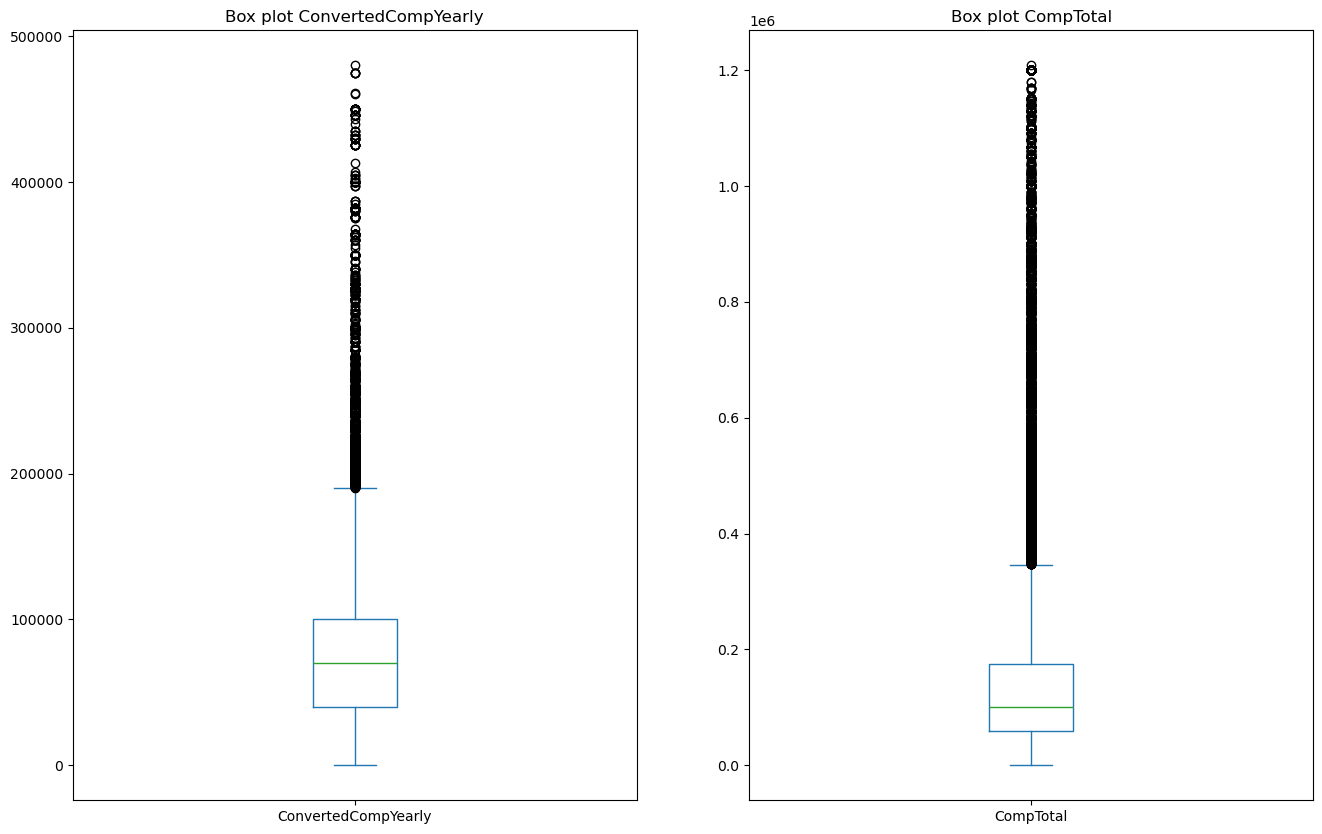

In [35]:
fig = plt.figure(figsize=(16,10))

ax0 = fig.add_subplot(1, 2,1) # add subplot 1 (1 row, 2 columns, first plot)
ax0 = df["ConvertedCompYearly"].plot(kind = "box")
plt.title("Box plot ConvertedCompYearly")
ax1 = fig.add_subplot(1, 2,2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
df["CompTotal"].plot(kind = "box")
plt.title("Box plot CompTotal")
plt.show()

We need to identify and handle these outliers. In order to proceed we will create a dataframe with no missing values, as the percentile function in numpy library returns NaN otherwise.

In [36]:
df_dropped_na = df.dropna(subset = ["ConvertedCompYearly","CompTotal"])

mean = df["ConvertedCompYearly"].mean()
std = df["ConvertedCompYearly"].std()
median = df["ConvertedCompYearly"].median()

print("The Yearly compensation in this dataset for the respondents is: ")
print("")
print(f"Median value:  {median:0.1f}$")
print(f"Mean value:  {mean:0.1f}$")
print(f"Standard deviation:  {std:0.1f}$")
print("--------------------------------")

threshold_value = mean + 3 * std

print(f"The salaries above {threshold_value:0.1f}$ are over 3 standard deviations above the mean")


mean = df["CompTotal"].mean()
std = df["CompTotal"].std()
median = df["CompTotal"].median()

print("The total compensation in this dataset for the respondents is: ")
print("")
print(f"Median value:  {median:0.1f}$")
print(f"Mean value:  {mean:0.1f}$")
print(f"Standard deviation:  {std:0.1f}$")
print("--------------------------------")

threshold_value = mean + 3 * std

print(f"The salaries above {threshold_value:0.1f}$ are over 3 standard deviations above the mean")


The Yearly compensation in this dataset for the respondents is: 

Median value:  69814.0$
Mean value:  78322.6$
Standard deviation:  58736.0$
--------------------------------
The salaries above 254530.7$ are over 3 standard deviations above the mean
The total compensation in this dataset for the respondents is: 

Median value:  100000.0$
Mean value:  167330.7$
Standard deviation:  210828.6$
--------------------------------
The salaries above 799816.7$ are over 3 standard deviations above the mean


In [37]:
Q1 = np.percentile(df_dropped_na["ConvertedCompYearly"], 25, interpolation = 'midpoint') 
Q3 = np.percentile(df_dropped_na["ConvertedCompYearly"], 75, interpolation = 'midpoint') 

print(f'The first quartile, 25 percentile of the yearly compensation is: {Q1}$')
print(f'The third quartile, 75 percentile of the yearly compensation is:  {Q3}$')

IQR = Q3 - Q1 
print('Interquartile range is', IQR)
upper = Q3 + 5 * IQR
lower = Q1 - 3 * IQR

print(f"The upper limit of yearly compensation is: {upper}$")
print(f"The lower limit of yearly compensation is: {lower}$")

df = df[(df["ConvertedCompYearly"] < upper) | (df["ConvertedCompYearly"].isna()) ]

The first quartile, 25 percentile of the yearly compensation is: 40000.0$
The third quartile, 75 percentile of the yearly compensation is:  100000.0$
Interquartile range is 60000.0
The upper limit of yearly compensation is: 400000.0$
The lower limit of yearly compensation is: -140000.0$


In [38]:
Q1 = np.percentile(df_dropped_na["CompTotal"], 25, interpolation = 'midpoint') 
Q3 = np.percentile(df_dropped_na["CompTotal"], 75, interpolation = 'midpoint') 

print(f'The first quartile, 25 percentile of the yearly compensation is: {Q1}$')
print(f'The third quartile, 75 percentile of the yearly compensation is:  {Q3}$')

IQR = Q3 - Q1 
print('Interquartile range is', IQR)
upper = Q3 + 5 * IQR
lower = Q1 - 3 * IQR

print(f"The upper limit of yearly compensation is: {upper}$")
print(f"The lower limit of yearly compensation is: {lower}$")

df = df[(df["CompTotal"] < upper) | (df["CompTotal"].isna())]

The first quartile, 25 percentile of the yearly compensation is: 60000.0$
The third quartile, 75 percentile of the yearly compensation is:  175000.0$
Interquartile range is 115000.0
The upper limit of yearly compensation is: 750000.0$
The lower limit of yearly compensation is: -285000.0$


We can now see that those extreme outliers in the CompTotal have been eliminated.

In [39]:
df["CompTotal"].max()

749958.0

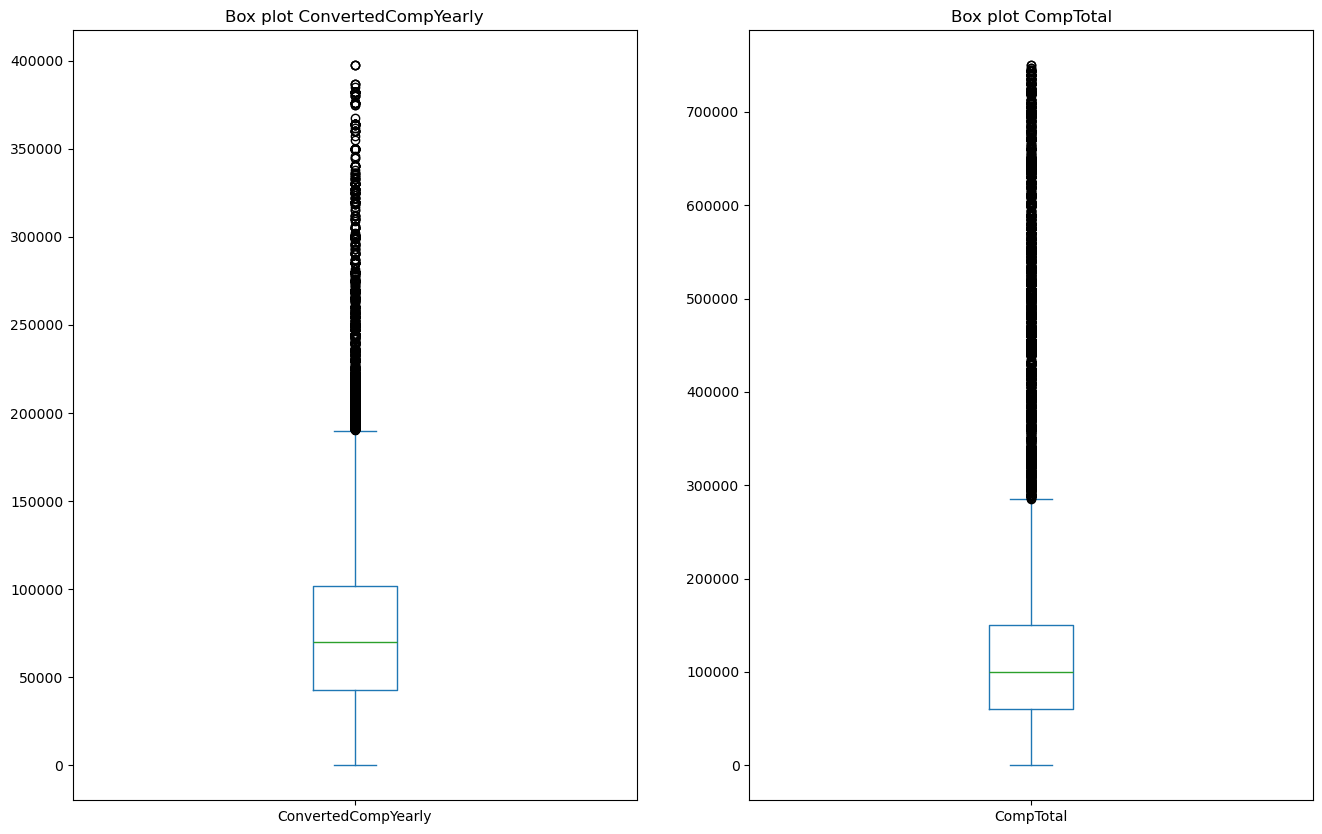

In [40]:
fig = plt.figure(figsize=(16,10))

ax0 = fig.add_subplot(1, 2,1) # add subplot 1 (1 row, 2 columns, first plot)
ax0 = df["ConvertedCompYearly"].plot(kind = "box")
plt.title("Box plot ConvertedCompYearly")
ax1 = fig.add_subplot(1, 2,2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
df["CompTotal"].plot(kind = "box")
plt.title("Box plot CompTotal")
plt.show()

Now we can replace missing values of ConvertedCompYearly and Compotal using a grouped median value. We will group by country,YearsCode,YearsCodePro,DevType and Employment. The following function will fill missing values by grouping with fewer and fewer features until most NaNs are filled.

In [41]:
def grouped_fillna_median(df, columns, target_col):

    column_count = len(columns)
 
    while column_count > 0:
        df[target_col] = df.groupby(columns[:column_count])[target_col].transform(lambda x: x.fillna(x.median()))
        column_count -= 1
        
    return df[target_col].fillna(value = df[target_col].median())



In [42]:
col_groups = ["Employment","Country","YearsCode","DevType","YearsCodePro"]

In [43]:
df["ConvertedCompYearly"] = grouped_fillna_median(df, col_groups, "ConvertedCompYearly")
df["CompTotal"] = grouped_fillna_median(df, col_groups, "CompTotal")

The next numerical data we need to fill missing values of are JobSat and JobSat_Mean. We can see from the following histograms that the distributions are skewed, so it is appropriate to use median value and the same function used previously.

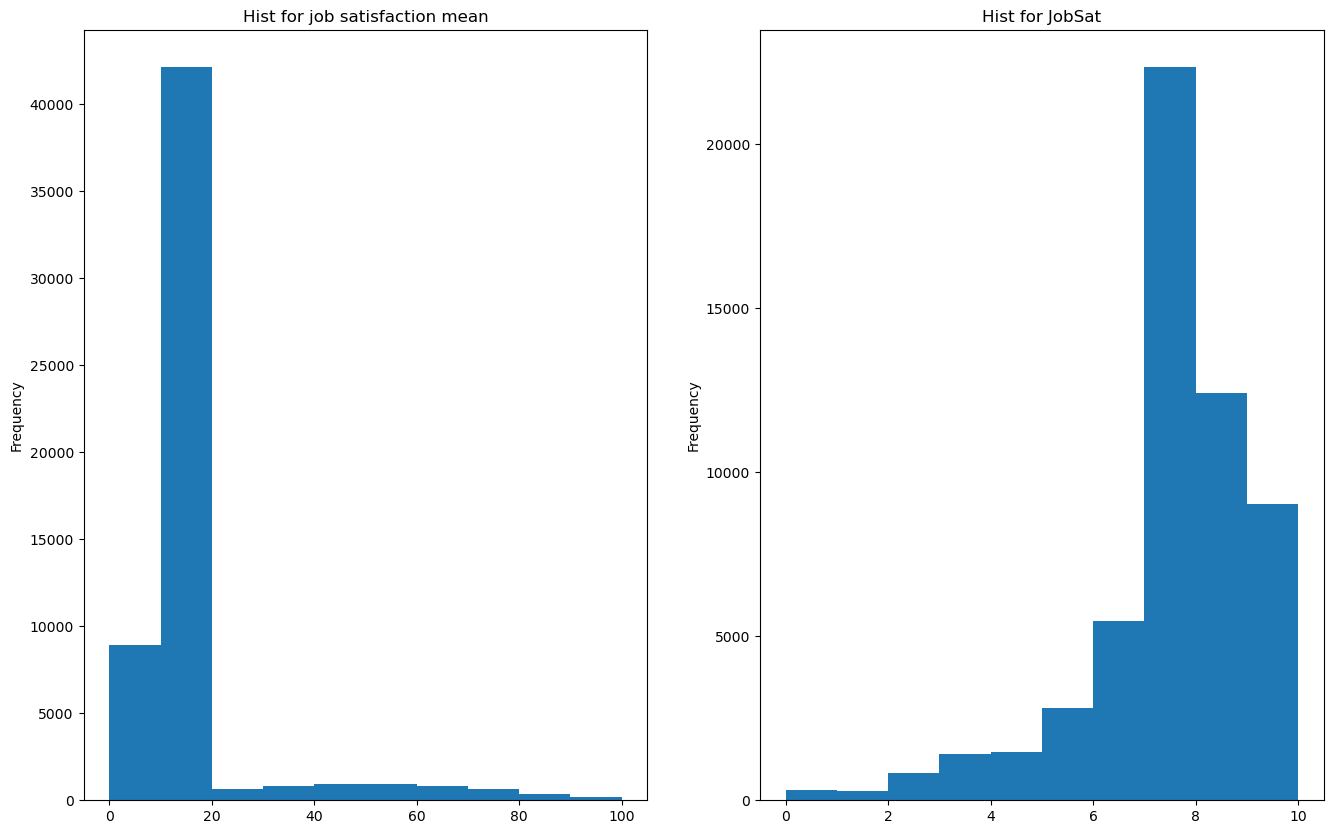

In [44]:
fig = plt.figure(figsize=(16,10))

ax0 = fig.add_subplot(1, 2,1) # add subplot 1 (1 row, 2 columns, first plot)
ax0 = df["JobSat_Mean"].plot(kind = "hist")
plt.title("Hist for job satisfaction mean")
ax1 = fig.add_subplot(1, 2,2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax1 = df["JobSat"].plot(kind = "hist")
plt.title("Hist for JobSat")
plt.show()

In [45]:
df["JobSat_Mean"] = grouped_fillna_median(df, col_groups, "JobSat_Mean")
df["JobSat"] = grouped_fillna_median(df, col_groups, "JobSat")

For the rest of the categorical columns we will simply replace the missing values with 'None'

In [47]:
df.fillna(value = "None", inplace= True)


In [48]:
df.isna().sum()

ResponseId                0
MainBranch                0
Age                       0
Employment                0
Country                   0
RemoteWork                0
DevType                   0
EdLevel                   0
YearsCode                 0
YearsCodePro              0
LanguageHaveWorkedWith    0
LanguageWantToWorkWith    0
LanguageAdmired           0
DatabaseHaveWorkedWith    0
DatabaseWantToWorkWith    0
DatabaseAdmired           0
PlatformHaveWorkedWith    0
PlatformWantToWorkWith    0
PlatformAdmired           0
WebframeHaveWorkedWith    0
WebframeWantToWorkWith    0
WebframeAdmired           0
CompTotal                 0
ConvertedCompYearly       0
JobSat_Mean               0
JobSat                    0
dtype: int64

### Cleaning uo trailing spaces

In [49]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

We have now completed the cleaning of the dataset for our purpose. We can now save this csv file as a new dataset that will be used for exploratory data analysis.

In [50]:
df.to_csv("survey-data_cleaned.csv")